# Tutorial `sdswrapper`

### A Python package for spatial data science workflows.

To install use: 
```bash
!pip install sdswrapper
```

Pacotes python:

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor 

from pykrige.rk import RegressionKriging
from pykrige.ok import OrdinaryKriging

import sdswrapper as sds

Instanciando os modelos de interesse:

In [2]:
model_list = [
    ('LinearRegression', LinearRegression()),
    ('RidgeRegression', Ridge()),
    ('LassoRegression', Lasso()),
    ('ElasticNetRegression', ElasticNet()),
    ('DecisionTreeRegression', DecisionTreeRegressor()),
    ('RandomForestRegression', RandomForestRegressor()),
    ('GradientBoostingRegression', GradientBoostingRegressor()),
    ('SupportVectorRegression', SVR()),
    ('KNearestNeighborsRegression', KNeighborsRegressor())
]

In [3]:
krige_models = list()

for model_name, model in model_list:

    if model_name == 'DecisionTreeRegression':

        continue

    krige_models.append(
        (
            'KrigingRegressionRF' + model_name,
            RegressionKriging(
                regression_model    = model,
                variogram_model     = 'linear',
                verbose             = False,
                nlags               = 10
            )
        )
    )

In [4]:
ordinary_kriging = sds.OrdinaryKrigingInterface()


model_list.append(
    ('OrdinaryKriging', ordinary_kriging)
)

In [5]:
model_list.extend(krige_models)

In [6]:
model_list

[('LinearRegression', LinearRegression()),
 ('RidgeRegression', Ridge()),
 ('LassoRegression', Lasso()),
 ('ElasticNetRegression', ElasticNet()),
 ('DecisionTreeRegression', DecisionTreeRegressor()),
 ('RandomForestRegression', RandomForestRegressor()),
 ('GradientBoostingRegression', GradientBoostingRegressor()),
 ('SupportVectorRegression', SVR()),
 ('KNearestNeighborsRegression', KNeighborsRegressor()),
 ('OrdinaryKriging', OrdinaryKrigingInterface()),
 ('KrigingRegressionRFLinearRegression',
  <pykrige.rk.RegressionKriging at 0x15ef71f50>),
 ('KrigingRegressionRFRidgeRegression',
  <pykrige.rk.RegressionKriging at 0x174da5450>),
 ('KrigingRegressionRFLassoRegression',
  <pykrige.rk.RegressionKriging at 0x174dea150>),
 ('KrigingRegressionRFElasticNetRegression',
  <pykrige.rk.RegressionKriging at 0x174dea290>),
 ('KrigingRegressionRFRandomForestRegression',
  <pykrige.rk.RegressionKriging at 0x174dea090>),
 ('KrigingRegressionRFGradientBoostingRegression',
  <pykrige.rk.RegressionKr

Dataset para testes:

In [7]:
sg = sds.SampleGenerator(
            y_filepath                      = sds.ABUNDANCE_FILEPATH,
            p_1_filepath                    = sds.P_1,
            p_2_filepath                    = sds.P_2,
            georreferenced_raster_filepath  = sds.SUITABILITY_FILEPATH
        )

In [8]:
df_y = sg.sample(10)

df_pseudoabsences = sg.sample(10, pseudoabsences=True)

dataset = pd.concat([df_y, df_pseudoabsences], axis=0)

In [9]:
dataset

,ID,coordenada_X,coordenada_Y,y,p_1,p_2
0,0.0,216.0,141.0,373.0,11.637667,1698.0
1,1.0,353.0,209.0,494.0,27.570499,3054.0
2,2.0,203.0,181.0,1000.0,11.190000,1465.0
3,3.0,317.0,155.0,480.0,27.659834,2207.0
4,4.0,380.0,259.0,1000.0,26.744333,2876.0
5,5.0,212.0,398.0,294.0,26.131166,3058.0
6,6.0,290.0,210.0,942.0,26.645666,2715.0
7,7.0,149.0,126.0,710.0,27.231834,3017.0
8,8.0,266.0,247.0,482.0,26.347500,2773.0
9,9.0,236.0,222.0,511.0,26.806334,2546.0


Wrapper:

In [10]:
sds_wrapper = sds.Wrapper(
    model_list              = model_list,
    dataset                 = dataset,
    X_column_names          = ['coordenada_X', 'coordenada_Y'],
    P_column_names          = [], #['p_1', 'p_2'],
    y_column_name           = 'y',
    projections_folder      = sds.PROJECTIONS_FOLDER,
    k                       = 5,
    gridsearch_parameters   = None
)

In [11]:
output = sds_wrapper.fit()

$#@%$#@%$#@%$#@%$#@%$#@%$#@%$#@%$#@%$#@%$#@%$#@%$#@%$#@%$#@%$#@%$#@%$#@%$#@%$#@%
p:
 Empty DataFrame
Columns: []
Index: []
$#@%$#@%$#@%$#@%$#@%$#@%$#@%$#@%$#@%$#@%$#@%$#@%$#@%$#@%$#@%$#@%$#@%$#@%$#@%$#@%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
self.P:
 None
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
`P` must be provided for Regression Kriging models. Skipping model: LinearRegression
`P` must be provided for Regression Kriging models. Skipping model: RidgeRegression
`P` must be provided for Regression Kriging models. Skipping model: LassoRegression
`P` must be provided for Regression Kriging models. Skipping model: ElasticNetRegression
`P` must be provided for Regression Kriging models. Skipping model: DecisionTreeRegression
`P` must be provided for Regression Kriging models. Skipping model: RandomForestRegression
`P` must be provided for Regression Kriging models. Skipping model: GradientBoostingRegression
`P` must be provided for Regression Kriging models. Skipping model: SupportVector

Inspecionando resultados dos modelos:

In [20]:
df_output = pd.DataFrame(output).sort_values(by='model_metrics_mean', ascending=True)

In [21]:
df_output

,sample_size,name,model_type,model_metrics_mean,model_metrics_std,trained_model
17,20,KrigingRegressionRFKNearestNeighborsRegression,KR,176.793859,95.443274,<pykrige.rk.RegressionKriging object at 0x17c2...
5,20,RandomForestRegression,SK,225.447418,121.125439,"(DecisionTreeRegressor(max_features=1.0, rando..."
8,20,KNearestNeighborsRegression,SK,226.223877,108.442054,KNeighborsRegressor()
14,20,KrigingRegressionRFRandomForestRegression,KR,229.547939,119.786212,<pykrige.rk.RegressionKriging object at 0x17c2...
1,20,RidgeRegression,SK,241.745945,92.487032,Ridge()
2,20,LassoRegression,SK,243.862108,75.842052,Lasso()
0,20,LinearRegression,SK,245.920020,75.353895,LinearRegression()
12,20,KrigingRegressionRFLassoRegression,KR,251.284672,77.609749,<pykrige.rk.RegressionKriging object at 0x17c2...
10,20,KrigingRegressionRFLinearRegression,KR,251.751198,77.921485,<pykrige.rk.RegressionKriging object at 0x17c2...
11,20,KrigingRegressionRFRidgeRegression,KR,251.867328,77.913198,<pykrige.rk.RegressionKriging object at 0x1791...


Projetando para a América do Sul e computando a qualidade das projecções:

In [22]:
df_full_data = sg.get_full_data()

In [23]:
df_full_data

,coordenada_X,coordenada_Y,y,p_1,p_2
0,0,0,0.0,-3.400000e+38,-3.400000e+38
1,1,0,0.0,-3.400000e+38,-3.400000e+38
2,2,0,0.0,-3.400000e+38,-3.400000e+38
3,3,0,0.0,-3.400000e+38,-3.400000e+38
4,4,0,0.0,-3.400000e+38,-3.400000e+38
...,...,...,...,...,...
1920298,1136,1682,0.0,-3.400000e+38,-3.400000e+38
1920299,1137,1682,0.0,-3.400000e+38,-3.400000e+38
1920300,1138,1682,0.0,-3.400000e+38,-3.400000e+38
1920301,1139,1682,0.0,-3.400000e+38,-3.400000e+38


In [24]:
model_id = 6

print('Model:', output[model_id]['name'])

prediction = sds_wrapper.predict(
    trained_model = output[model_id]['trained_model'],
    X = df_full_data[['coordenada_X', 'coordenada_Y']],
    p = df_full_data[['p_1', 'p_2']],
    shape = sg.y.shape
)

Model: GradientBoostingRegression


In [25]:
sds_wrapper.score(
    np.where(np.isnan(prediction), -1, prediction),
    np.where(np.isnan(sg.y), -1, sg.y),
)

174.1373488189239

In [26]:
prediction = np.where(np.isnan(sg.y), np.nan, prediction)

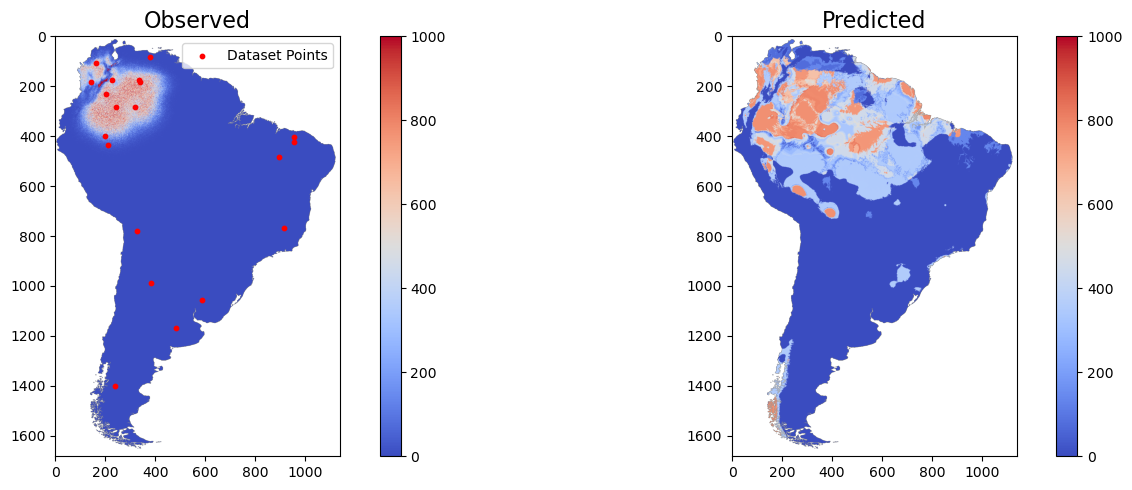

In [27]:
fig = plt.figure(figsize=(15, 5))

# Plotando o mapa observado
ax1 = plt.subplot(1, 2, 1)
plt.imshow(sg.y, cmap='coolwarm', vmin=0, vmax=1000)
plt.colorbar()
plt.title('Observed', fontsize=16)

# Adicionando os pontos do dataset
plt.scatter(dataset['coordenada_X'], dataset['coordenada_Y'], 
            c='red', s=10, label='Dataset Points')
plt.legend()

# Plotando o mapa previsto
ax2 = plt.subplot(1, 2, 2)
plt.imshow(prediction, origin='lower', cmap='coolwarm', vmin=0, vmax=1000)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('Predicted', fontsize=16)

plt.tight_layout()

Text(0.5, 1.0, 'Error in Predicted Y')

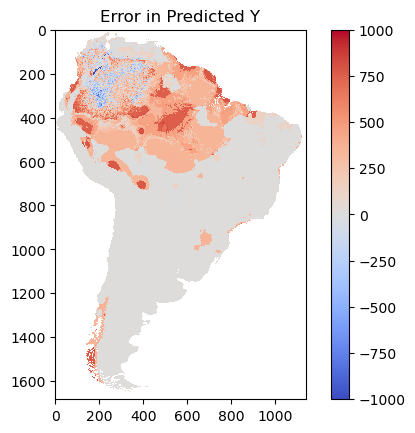

In [28]:
plt.imshow( (prediction - sg.y), cmap='coolwarm', interpolation='nearest', vmin=-1000, vmax=1000)
plt.colorbar()
plt.title('Error in Predicted Y')

Gráfico do Wrapper:

In [29]:
df_output['prediction']  = df_output['trained_model'].apply(lambda x: sds_wrapper.predict(
    trained_model = x,
    X = df_full_data[['coordenada_X', 'coordenada_Y']],
    p = df_full_data[['p_1', 'p_2']],
    shape = sg.y.shape
))

In [30]:
df_output['prediction']  = df_output['prediction'].apply(lambda x: sds_wrapper.mask(x, sg.y))

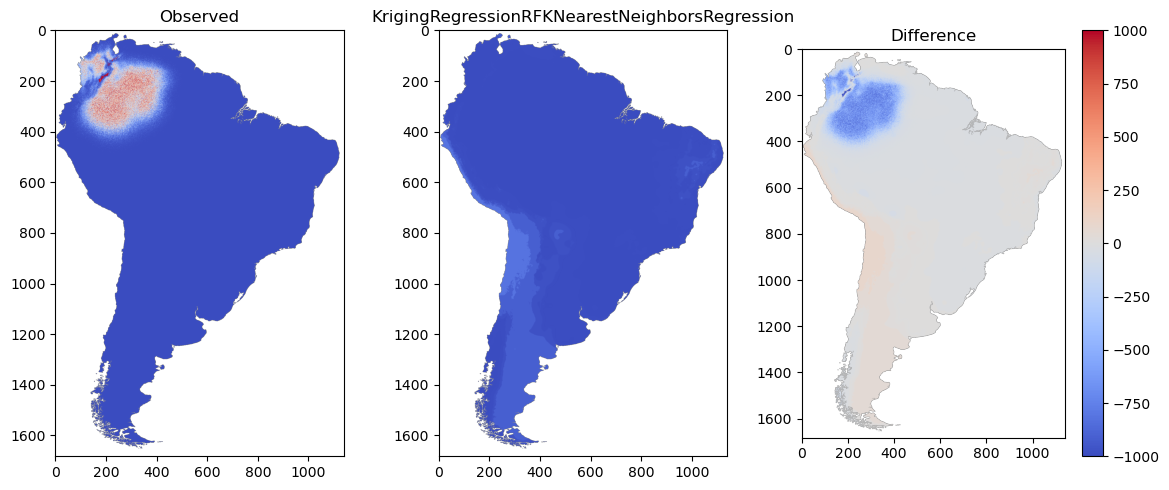

In [32]:
sds_wrapper.plot(df_output, reference_data = sg.y, best = True)

In [ ]:
# End #